In [1]:
import keras.layers
import numpy as np
import os
import eofs
from eofs.standard import Eof
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import optimizers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from keras.models import save_model
from keras.models import load_model


import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
from torch.autograd import Variable 


import xml.etree.ElementTree as ET





import process_xml as px
import test_data as td
import sim_data_4_sc as sd
import pandas as pd
#from vtu_class import *

In [2]:
####### VTU CLASS #########

import sys
sys.path.append('fluidity-master')
import vtktools


class vtufile:
    def __init__(self, name):
        """
        Creates the vtu object for the file name.vtu
        """
        self.name = name
        self.file = vtktools.vtu(name+'.vtu')



    def getField(self):
        """
        Returns a tuple containing the values of the tracer at the timestamp
        """
        self.file.GetFieldNames()
        field = self.file.GetScalarField('tracer1')
        return field
        
        
        
    def setField(self, target):
        """
        Modifies the values of the field in the object (not in the .vtu file)
        """
        self.file.AddScalarField('tracer1', target)
        
    def save_as(self, target_name):
        """
        Creates the file target_name.vtu containing the updated field
        """
        self.file.Write(target_name+".vtu")
        
        
        
"""###### Example ######
cube7 = vtufile("cube_disp_7")
f = cube7.getField()
print(f)
cube7.setField(4*f)
cube7.save_as("cube_disp_7_bis")
cube_bis = vtufile("cube_disp_7_bis")
print(cube_bis.getField())"""



'###### Example ######\ncube7 = vtufile("cube_disp_7")\nf = cube7.getField()\nprint(f)\ncube7.setField(4*f)\ncube7.save_as("cube_disp_7_bis")\ncube_bis = vtufile("cube_disp_7_bis")\nprint(cube_bis.getField())'

In [3]:
####### BUILDING DATA ########

def run_simulation(flml,n_time,freq_check_point=25):
    """
    Runs fluidity on the given flml file to generate the .vtu files, up to n_time timestamps
    """
    
    #Commands to run fluidity
    os.system("fluidity/bin/fluidity -l -v3 "+flml+".flml &")
    
    #Waiting for the simulation
    not_found = True
    target_vtu = px.get_next_name(flml, n_time)
    while not_found:
        try:
            with open(target_vtu +".vtu") : pass
            not_found = False
        except:
            time.sleep(2)
            
    #Safety
    time.sleep(2)
            
    #Commands to stop fluidity ##### WARNING : may take more than 1 second
    os.system("killall fluidity")
    
    
    
def build_data_from_simu(flml_name, n_time, n_begin=0):
    """
    Once data has been generated from the flml_name file,
    takes the chosen batch of timestamps and put the values
    of the field in a numpy array
    """
    
    X_vtu = []
    
    name = px.get_simulation_name(flml_name)
    
    for n in range(n_begin, n_time+1):
        vtu = vtufile(name + "_" +str(n)+ ".vtu")
        X_vtu.append(np.array(vtu.getField()))
    return np.array(X_vtu)

        




In [4]:
######### USEFUL METHODS


def custom_loss(simu_original, simu_from_previous, pred, rate=0.5):
    """
    Loss function balanced between the two errors
    """
    
    classic = torch.mean((pred - simu_original)**2)
    physics_informed = torch.mean((pred - simu_from_previous)**2)
    
    return rate*classic + (1-rate)*physics_informed
    
    
    
    
    
def run_step_simu_from(flml_name, vtu_name, n=1):
    """
    Runs n steps of simulation from the flml_name file from the vtu_name 
    initial condition.
        
    It returns the predicted field in a tuple.
    """
    
    #modifying the vtu reference in the flml file
    px.set_vtu_ref(flml_name, vtu_name+'.vtu')
    
    
    
    
    #running the simulation
    os.system("fluidity/bin/fluidity -l -v3 "+flml_name+".flml &")
    
    #waiting
    vtu_target = px.get_next_name(flml_name,n)
    not_found = True
    while not_found:
        try:
            with open(vtu_target +".vtu") : pass
            not_found = False
        except:
            time.sleep(2)
            
            
    #3 seconds safety
    time.sleep(2)
            
    #Commands to stop fluidity
    os.system("killall fluidity")
    
    
    
    #Extracting values
    vfile = vtu_file(vtu_target)
    simu_from_previous = vfile.getField()
    
    return simu_from_previous
    


Input_dim : 10288 ; reduced dim : 323


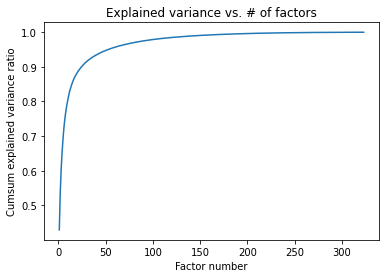

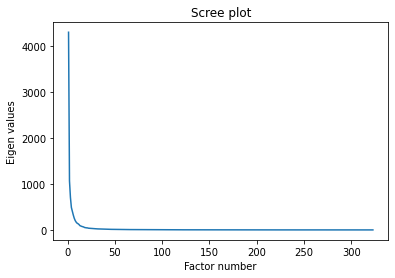

In [6]:

#DATASET BUILDING

#X_train_1, X_test_1, Y_train_1, Y_test_1, sc_mto, acp_mto, sc2_mto = sd.build_mto(70, pca=True, pca_details=True, shuffle=True)

X_train, X_test, Y_train, Y_test, sc, acp, sc2 = sd.build(70, pca=True, pca_details=True, shuffle=True)





In [7]:





print(X_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(Y_train.shape)




(70, 323)
(10, 323)
(10, 3, 323)
(70, 3, 323)


In [9]:
# LEARNING ARCHITECTURE : OTM DATA DRIVEN LSTM


X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

Y_train_tensors = Variable(torch.Tensor(Y_train))
Y_test_tensors = Variable(torch.Tensor(Y_test)) 

#Reshape
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], X_test_tensors.shape[1]))




class OneToManyRNN(nn.Module):
    def __init__(self, rnn_cell):
        super(OneToManyRNN, self).__init__()
        self.rnn_cell = rnn_cell
        

        
        ##### LAYERS ######
        
        self.fc_1 =  nn.Linear(hidden_size, input_size) #fully connected 1
        self.fc = nn.Linear(input_size, input_size) #fully connected last layer
        self.activation = nn.Sigmoid()
        
        
        

    def forward(self, x, n_steps = 3):
        # x has shape (batch_size, input_dim)

        outputs = []
        hidden = None 
        #hidden = (torch.zeros(X_train_tensors_final.shape), torch.zeros(X_train_tensors_final.shape))
        for _ in range(n_steps):
            hidden = self.rnn_cell(x, hidden)
            
            if type(hidden) == tuple:
                outputs.append(hidden[0].clone())
                x = hidden[0].clone()
            else:
                outputs.append(hidden.clone())
                x = hidden.clone()

        outputs = torch.stack(outputs, dim = 1)
        
        
        ###### LAYERS #######
        
        #out = self.activation(outputs)
        out = self.fc_1(outputs) #first Dense
        #out = self.activation(out)
        #out = self.fc(outputs)
        return out

        #return outputs
    
    
input_size = 323
hidden_size = 323
learning_rate = 0.0001
num_epochs = 700


rnn_cell = nn.LSTMCell(input_size, hidden_size) 
model = OneToManyRNN(rnn_cell)


loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


losses9 = []
pourtest2 = []

# TRAINING LOOP #

for epoch in range(num_epochs):
    
    output = model.forward(X_train_tensors_final)
    loss = loss_function(output, Y_train_tensors)
    loss.backward()
    optimizer.step()
    
    
    test=model.forward(X_test_tensors_final)
    loss_test = loss_function(test, Y_test_tensors)
    pourtest2.append(loss_test.item())
    
    losses9.append(loss.item())
    
    if epoch % 100 == 0:
        print("Epoch: "+str(epoch)+", loss: "+ str(loss.item()))
        print("Test loss : " + str(loss_test.item()))
        
        
        
        
        
        
#print(output)
        
    
#plt.plot(range(len(losses)), losses)
#plt.show()






Epoch: 0, loss: 1.0041643381118774
Test loss : 1.004615068435669
Epoch: 100, loss: 0.8848648071289062
Test loss : 1.005815863609314
Epoch: 200, loss: 0.675809919834137
Test loss : 1.011083960533142
Epoch: 300, loss: 0.5038968920707703
Test loss : 1.0181879997253418
Epoch: 400, loss: 0.36878296732902527
Test loss : 1.0252646207809448
Epoch: 500, loss: 0.2682672441005707
Test loss : 1.0364526510238647
Epoch: 600, loss: 0.1974978744983673
Test loss : 1.0540976524353027
tensor([[[ 6.7731e-01, -5.6930e-02,  8.1593e-01,  ..., -8.3557e-01,
          -6.5518e-01, -1.1659e+00],
         [-3.4109e-01,  5.4998e-01, -2.5493e-01,  ..., -6.5666e-01,
           2.1567e+00, -5.3723e-01],
         [-5.8710e-01, -5.7105e-01, -1.0864e+00,  ...,  5.0254e+00,
           9.3919e+00, -8.6691e-01]],

        [[ 2.4524e-01,  5.2763e-01, -7.4673e-01,  ..., -1.6024e-01,
          -6.2651e-01, -2.1573e-01],
         [-2.6630e-01,  1.1653e-01, -1.0207e+00,  ...,  6.2725e-01,
          -1.1221e-01, -6.9082e-01],
  

NameError: name 'losses' is not defined

In [12]:
#SAVING LOSS EVOLUTION

losses9 = np.loadtxt("lossesrep.csv")
pourtest2 = np.loadtxt("lossesreptest.csv")

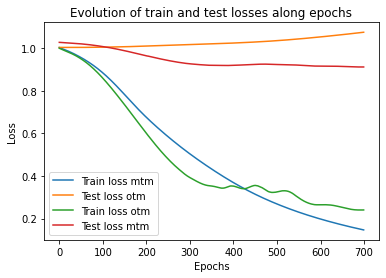

In [25]:
#PLOTTING COMPARATIVE LOSSES

#plt.plot(range(len(losses9)), losses9, label="Train loss mtm")
#plt.plot(range(len(pourtest2)), pourtest2, label="Test loss otm")
#plt.plot(range(len(losses9)), losses7/5, label="Train loss otm")
#plt.plot(range(len(pourtest2)), pourtest[:700]/16, label="Test loss mtm")
#plt.title("Pë")
#plt.legend()
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.show()




In [ ]:
# FURTHER PARAMETERS EXLPLORATION : BDLSTM, NB OF LAYERS...

X_train_tensors_final = Variable(torch.Tensor(X_train_1))
X_test_tensors_final = Variable(torch.Tensor(X_test_1))

Y_train_tensors = Variable(torch.Tensor(Y_train_1))
Y_test_tensors = Variable(torch.Tensor(Y_test_1)) 



class LSTM1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, bid=False):
        super(LSTM1, self).__init__()
        
        self.bid = bid
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, bidirectional=bid) #lstm
        
        self.fc_1 =  nn.Linear(hidden_size,input_size)
        self.fc = nn.Linear(input_size, input_size)
        self.fc_2 = nn.Linear(input_size, input_size)

        self.activation = nn.Tanh()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros((self.bid+1)*self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros((self.bid+1)*self.num_layers, x.size(0), self.hidden_size)) #internal state
        
        
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        #print(hn.shape)
        #hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        hn = hn[-1]
        #print(hn.shape)
        #out = self.activation(hn)
        out = self.fc_1(hn)
#        out = self.activation(out)
        out = self.fc(out)
#        out = self.activation(out)
#        out = self.fc_2(out)
        return out
    
    
input_size = 323
hidden_size = 323
learning_rate = 0.00009
num_epochs = 100
num_layers = 2
bid = False


model = LSTM1(input_size, hidden_size, num_layers, bid)  # or GRUCell or RNNCell


loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


losses7 = []

pourtest = []

for epoch in range(num_epochs):
    
    output = model.forward(X_train_tensors_final)
    loss = loss_function(output, Y_train_tensors)
    loss.backward()
    optimizer.step()
    
    losses7.append(loss.item())
    
    test=model.forward(X_test_tensors_final)
    loss_test = loss_function(test, Y_test_tensors)
    pourtest.append(loss_test.item())
    
    if epoch % 100 == 0:
        print("Epoch: "+str(epoch)+", loss: "+ str(loss.item()))
        
        test=model.forward(X_test_tensors_final)
        loss_test = loss_function(test, Y_test_tensors)
        pourtest.append(loss_test.item())
        print("Test loss : " + str(loss_test.item()))
        
print(output)
print(output.shape)
        
    
plt.plot(range(len(losses7)), losses7)
plt.plot(range(len(pourtest)), pourtest)
plt.show()

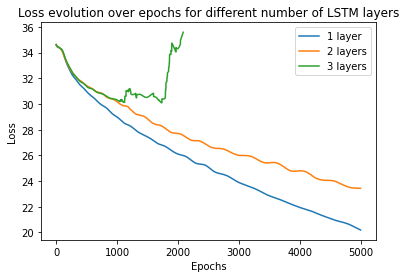

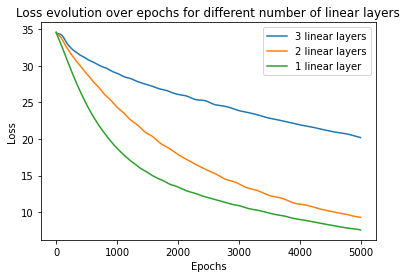

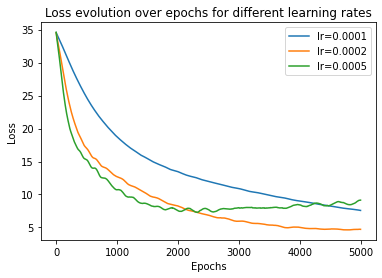

In [97]:
# FURTHER PLOTTINGS

plt.plot(range(len(losses)), losses, label="1 layer")
plt.plot(range(len(losses1)), losses1, label="2 layers")
plt.plot(range(len(losses2)), losses2, label="3 layers")
plt.title("Loss evolution over epochs for different number of LSTM layers")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


plt.plot(range(len(losses)), losses, label="3 linear layers")
plt.plot(range(len(losses1)), losses3, label="2 linear layers")
plt.plot(range(len(losses4)), losses4, label="1 linear layer")
plt.title("Loss evolution over epochs for different number of linear layers")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.plot(range(len(losses)), losses4, label="lr=0.0001")
plt.plot(range(len(losses1)), losses6, label="lr=0.0003")
plt.plot(range(len(losses4)), losses5, label="lr=0.0005")
plt.title("Loss evolution over epochs for different learning rates")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()



In [ ]:
###### FOLLOWING : FIRST ARCHITECTURE THAT RAN ONLY WITH A DIFFERENT DATASET DURING THE FIRST MONTH OF THE PROJECT

In [17]:
######## BDLSTM ########



X_train = np.zeros((3,3,3))

y_train = np.zeros((3,3,3))




hidden_size = 32 #64 ?
i1 = 2
i2 = 2
backY = 1

#instantiating the keras tensor
input_lstm = tf.Input((i1,i2))

#building the BDLSTM with dropout feature (avoiding overfitting)
lstm_1 = tf.layers.Bidirectional(tf.layers.LSTM(hidden_size, return_sequences=False))(input_lstm)
dropout_1 = tf.layers.Dropout(0.5)(lstm_1)

#normalization and repeat layers
bn_1 = tf.layers.BatchNormalization()(lstm_1)
rv_1 = tf.layers.RepeatVector(backY)(bn_1)

#output time distributed layer
dense_1 = tf.layers.TimeDistributed(tf.layers.Dense(X_train.shape[2], activation='sigmoid'))(rv_1)


#creating and printing the model
lstm_model = tf.Model(input_lstm, dense_1)
lstm_model.summary()



#training phase TO MOIFY : NO ACCESS TO THE LOSS
lstm_model.compile(loss='mean_squared_error', metrics=['mae'], optimizer='nadam')
history = lstm_model.fit(X_train, y_train, epochs=500, batch_size=8, verbose=2, validation_data = (X_test, y_test), shuffle = True)


#plotting the loss
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 2, 2)]            0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 64)                8960      
_________________________________________________________________
batch_normalization_6 (Batch (None, 64)                256       
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 1, 64)             0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 3)              195       
Total params: 9,411
Trainable params: 9,283
Non-trainable params: 128
_________________________________________________________________


NameError: name 'X_test' is not defined

In [20]:
######### STACKING LSTM ##########

lstm_units = 64
output_shape = 1000 # TO MODIFY

# Initialisation of the RNN with one LSTM and a Dropout
model = Sequential()
model.add(LSTM(lstm_units, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding two LSTMs and their dropout
model.add(LSTM(lstm_units, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(lstm_units))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(output_shape))

# printing the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 3, 64)             16896     
_________________________________________________________________
dropout_7 (Dropout)          (None, 3, 64)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 3, 64)             33024     
_________________________________________________________________
dropout_8 (Dropout)          (None, 3, 64)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)             